# Dataset Directory Inspection


In [ ]:


import os

root = "/content/drive/MyDrive/CVPR[Data_set]"

print("Root exists:", os.path.exists(root))
print("\n--- Top-level contents ---")
for name in sorted(os.listdir(root)):
    path = os.path.join(root, name)
    print(("DIR " if os.path.isdir(path) else "FILE"), "-", name)

print("\n--- One-level-deep preview ---")
for name in sorted(os.listdir(root)):
    path = os.path.join(root, name)
    if os.path.isdir(path):
        items = sorted(os.listdir(path))
        print(f"\n[{name}] -> {len(items)} items")
        # show up to first 30 names
        for item in items[:30]:
            p2 = os.path.join(path, item)
            print("  ", ("DIR " if os.path.isdir(p2) else "FILE"), "-", item)
        if len(items) > 30:
            print("   ...")


Root exists: True

--- Top-level contents ---
DIR  - animal_dataset
FILE - animal_dataset.zip

--- One-level-deep preview ---

[animal_dataset] -> 3 items
   DIR  - cat
   DIR  - dog
   DIR  - panda


# Mount Drive & Dataset Location

In [ ]:
import os

root = "/content/drive/MyDrive/CVPR[Data_set]/animal_dataset"
classes = ["cat", "dog", "panda"]
exts = (".jpg", ".jpeg", ".png", ".bmp")

print("Root exists:", os.path.exists(root))
print("\nImage counts per class:")

all_paths = []
total = 0

for cls in classes:
    p = os.path.join(root, cls)
    all_paths.append(p)

    if not os.path.exists(p):
        print(f"   {cls}: folder not found -> {p}")
        continue

    files = [f for f in os.listdir(p) if f.lower().endswith(exts)]
    count = len(files)
    total += count
    print(f"   {cls}: {count} images")

print("\nTotal images found:", total)
print("\nClass folder paths:")
for p in all_paths:
    print(" ", p)


Root exists: True

Image counts per class:
   cat: 100 images
   dog: 100 images
   panda: 100 images

Total images found: 300

Class folder paths:
  /content/drive/MyDrive/CVPR[Data_set]/animal_dataset/cat
  /content/drive/MyDrive/CVPR[Data_set]/animal_dataset/dog
  /content/drive/MyDrive/CVPR[Data_set]/animal_dataset/panda


# Dataset Loading & Preprocessing

Image counts per class:
  cat: 100 images
  dog: 100 images
  panda: 100 images

Image Data shape: (300, 1024)
Labels shape: (300,)


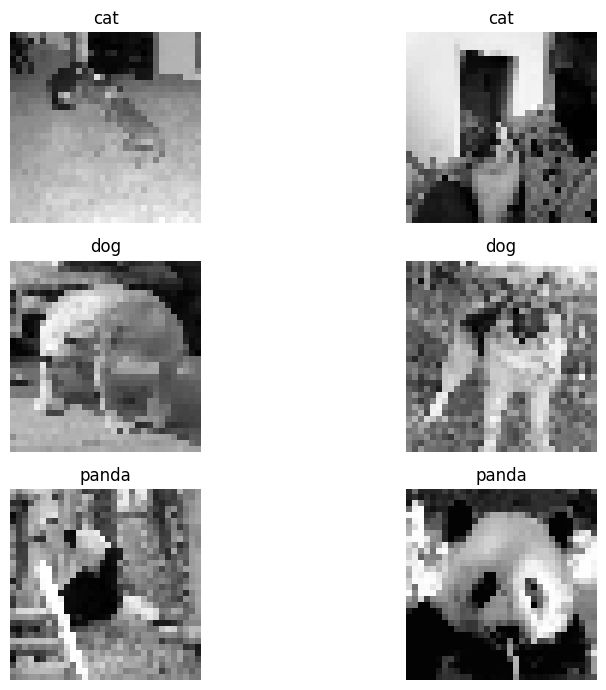

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Paths (your context)
cat_path   = "/content/drive/MyDrive/CVPR[Data_set]/animal_dataset/cat"
dog_path   = "/content/drive/MyDrive/CVPR[Data_set]/animal_dataset/dog"
panda_path = "/content/drive/MyDrive/CVPR[Data_set]/animal_dataset/panda"

all_paths = [cat_path, dog_path, panda_path]
classes = ["cat", "dog", "panda"]
image_size = (32, 32)

def load_dataset(all_paths, classes, image_size):
    data, labels = [], []

    for path in all_paths:
        folder_name = os.path.basename(path)

        if folder_name not in classes:
            print(f"Folder '{folder_name}' does not match class list")
            continue

        label = classes.index(folder_name)

        for file in os.listdir(path):
            if not file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                continue

            img_path = os.path.join(path, file)
            img = cv2.imread(img_path)
            if img is None:
                continue

            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            gray = cv2.resize(gray, image_size)

            data.append(gray.flatten().astype(np.float32))
            labels.append(label)

    data = np.array(data) / 255.0
    labels = np.array(labels, dtype=np.int64)
    return data, labels

data, labels = load_dataset(all_paths, classes, image_size)

print("Image counts per class:")
for i, cls in enumerate(classes):
    print(f"  {cls}: {np.sum(labels == i)} images")

print("\nImage Data shape:", data.shape)   # expected (300, 1024)
print("Labels shape:", labels.shape)      # expected (300,)

# Quick visualization (2 samples per class)
images_per_class = 2
plt.figure(figsize=(10, 7))
plot_index = 1

for label_index, cls in enumerate(classes):
    cls_idx = np.where(labels == label_index)[0]
    chosen_idx = np.random.choice(cls_idx, images_per_class, replace=False)

    for idx in chosen_idx:
        img = (data[idx].reshape(32, 32) * 255).astype(np.uint8)
        plt.subplot(len(classes), images_per_class, plot_index)
        plt.imshow(img, cmap="gray")
        plt.title(cls)
        plt.axis("off")
        plot_index += 1

plt.tight_layout()
plt.show()


# k-NN Classifier: Distance Metrics (L1 & L2) and Majority-Vote Prediction


In [ ]:
def l1_distance(x, y):
    return np.sum(np.abs(x - y))

def l2_distance(x, y):
    return np.sqrt(np.sum((x - y) ** 2))

def k_nearest_neighbors(X_train, y_train, x_query, k, distance_metric):
    distances = [(distance_metric(x_query, X_train[i]), y_train[i])
                 for i in range(len(X_train))]
    distances.sort(key=lambda x: x[0])
    k_labels = [label for _, label in distances[:k]]
    return max(set(k_labels), key=k_labels.count)


# 5-Fold Cross-Validation: K Sweep (1–15), Accuracy Plot (L1 vs L2), and Best Model Selection


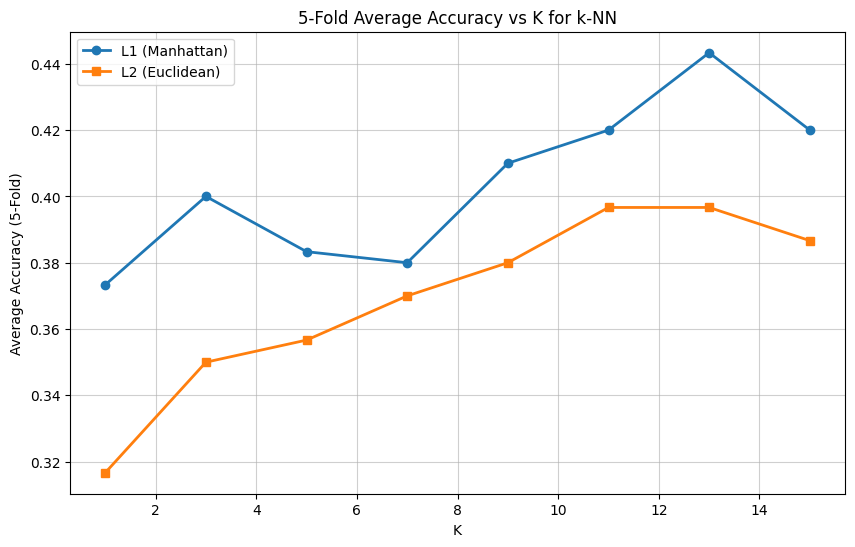

Best choice → K = 13 , Distance = L1
Best L1 avg accuracy: 0.44333333333333336
Best L2 avg accuracy: 0.39666666666666667


In [ ]:
folds = 5

def cross_validate(data, labels, k_values, distance_metric, folds):
    n = len(data)
    indices = np.arange(n)
    np.random.shuffle(indices)

    fold_ind = np.array_split(indices, folds)
    acc_results = {k: [] for k in k_values}

    for fold in range(folds):
        test_idx = fold_ind[fold]
        train_idx = np.hstack([fold_ind[i] for i in range(folds) if i != fold])

        train_X, train_y = data[train_idx], labels[train_idx]
        test_X, test_y = data[test_idx], labels[test_idx]

        for k in k_values:
            correct = 0
            for x, y_true in zip(test_X, test_y):
                pred = k_nearest_neighbors(train_X, train_y, x, k, distance_metric)
                if pred == y_true:
                    correct += 1

            acc_results[k].append(correct / len(test_y))

    avg_acc = {k: np.mean(acc_results[k]) for k in k_values}
    return avg_acc

k_values = [1, 3, 5, 7, 9, 11, 13, 15]

acc_l1 = cross_validate(data, labels, k_values, l1_distance, folds)
acc_l2 = cross_validate(data, labels, k_values, l2_distance, folds)

plt.figure(figsize=(10, 6))
plt.plot(k_values, [acc_l1[k] for k in k_values], marker="o", linewidth=2, label="L1 (Manhattan)")
plt.plot(k_values, [acc_l2[k] for k in k_values], marker="s", linewidth=2, label="L2 (Euclidean)")
plt.xlabel("K")
plt.ylabel("Average Accuracy (5-Fold)")
plt.title("5-Fold Average Accuracy vs K for k-NN")
plt.grid(True, alpha=0.6)
plt.legend()
plt.show()

best_k_l1 = max(acc_l1, key=acc_l1.get)
best_k_l2 = max(acc_l2, key=acc_l2.get)

if acc_l1[best_k_l1] >= acc_l2[best_k_l2]:
    best_distance = "L1"
    best_k = best_k_l1
    dist_func = l1_distance
else:
    best_distance = "L2"
    best_k = best_k_l2
    dist_func = l2_distance

print("Best choice → K =", best_k, ", Distance =", best_distance)
print("Best L1 avg accuracy:", acc_l1[best_k_l1])
print("Best L2 avg accuracy:", acc_l2[best_k_l2])


# Top-5 Test-Fold Predictions Using the Best k-NN Model (Qualitative Results)


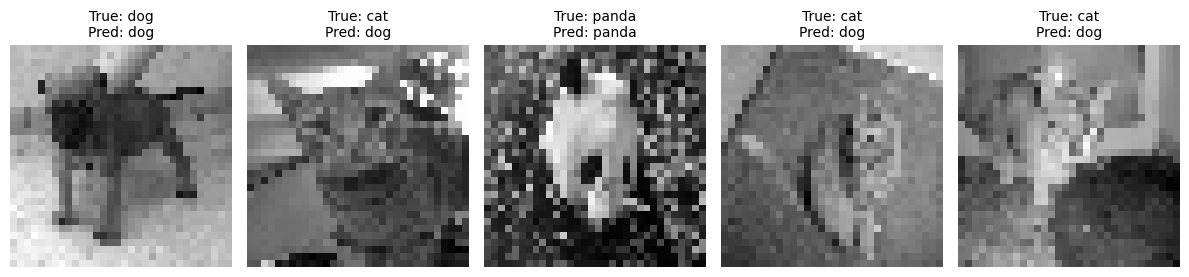

Shown samples: 5
Correct: 2
Accuracy on shown samples (%): 40.0


In [ ]:
folds = 5
k_values = [1, 3, 5, 7, 9, 11, 13, 15]

n = len(data)
indices = np.arange(n)
np.random.shuffle(indices)
fold_ind = np.array_split(indices, folds)

fold = 0
test_idx = fold_ind[fold]
train_idx = np.hstack([fold_ind[i] for i in range(folds) if i != fold])

X_train, y_train = data[train_idx], labels[train_idx]
X_test, y_test = data[test_idx], labels[test_idx]

chosen = np.random.choice(len(X_test), 5, replace=False)

plt.figure(figsize=(12, 3))
correct = 0

for j, idx in enumerate(chosen, start=1):
    x = X_test[idx]
    y_true = y_test[idx]
    y_pred = k_nearest_neighbors(X_train, y_train, x, best_k, dist_func)

    if y_pred == y_true:
        correct += 1

    img = (x.reshape(image_size) * 255).astype(np.uint8)

    plt.subplot(1, 5, j)
    plt.imshow(img, cmap="gray")
    plt.title(f"True: {classes[y_true]}\nPred: {classes[y_pred]}", fontsize=10)
    plt.axis("off")

plt.tight_layout()
plt.show()

print("Shown samples:", 5)
print("Correct:", correct)
print("Accuracy on shown samples (%):", (correct / 5) * 100)




In this assignment, we compared Manhattan (L1) and Euclidean (L2) distances for a k-NN classifier using our 3-class dataset (cat, dog, panda). We converted every image to 32×32 grayscale, flattened it into 1024 features, and tested the model using 5-fold cross-validation for different values of K.

From our results, L1 worked better than L2. The accuracy graph showed that the best setup was L1 with K = 13, with an average accuracy of 0.4433, while the best L2 result was 0.3967. In general, L1 stayed more consistent across different K values. This makes sense because we are using raw pixel values in a high-dimensional space, and L1 is often less sensitive to small noise than L2. We also noticed that very small K values gave weaker results, and performance improved when K was increased to a moderate range (around 9 to 15).

# Limitations:
The dataset is small (300 images total).

We used raw pixels instead of better features.

After resizing, some images (especially cat vs dog) look very similar.

k-NN becomes slow when the feature size is large.

# Improvements:
To get better accuracy, we could use feature extraction like HOG, reduce dimensions using PCA, or use CNN-based features. Adding more images or using data augmentation would also help.